In [1]:
! mkdir ~/.kaggle
! kaggle datasets download -d andrewmvd/car-plate-detection
! unzip car-plate-detection.zip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
100% 203M/203M [00:11<00:00, 21.6MB/s]
100% 203M/203M [00:11<00:00, 18.0MB/s]
Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: anno

In [2]:
import cv2
from matplotlib import pyplot as plt
import os
from random import sample, choice, randint
import numpy as np
import xml.etree.ElementTree as ET

In [3]:
image_dim = 300 # the image will be 300*300

In [4]:
def draw_bbox(image, bbox, predict_bbox = None):
  image = cv2.resize(image, (image_dim,image_dim),  interpolation=cv2.INTER_AREA)

  image = cv2.rectangle(image,  (int(bbox[0]*image_dim), int(bbox[1]*image_dim)),
                                (int(bbox[2]*image_dim), int(bbox[3]*image_dim)),
                                (0,100,0),2)
  if predict_bbox is not None:
    image= cv2.rectangle(image, (int(predict_bbox[0]*image_dim), int(predict_bbox[1]*image_dim)),
                                (int(predict_bbox[2]*image_dim), int(predict_bbox[3]*image_dim)),
                                (100,100,0),2)

  return image

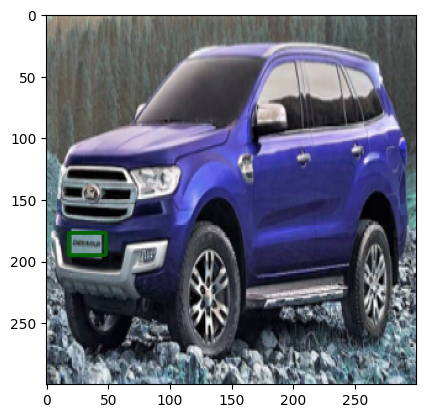

In [5]:
folder_path = "images"
random_file = choice(os.listdir(folder_path))
img_path = f'{folder_path}/{random_file}'  # Replace with your image path
label_path = "annotations/" + random_file[:-4] + ".xml"

#getting labels
tree = ET.parse(label_path)
root = tree.getroot()

width = int(root.find("size/width").text)
height = int(root.find("size/height").text)
xmin = int(root.find('object/bndbox/xmin').text)
ymin = int(root.find('object/bndbox/ymin').text)
xmax = int(root.find('object/bndbox/xmax').text)
ymax = int(root.find('object/bndbox/ymax').text)

#normalization
xmin = (xmin/width)
xmax = (xmax/width)
ymin = (ymin/height)
ymax = (ymax/height)

bbox = [xmin,ymin,xmax,ymax]

img = cv2.imread(img_path)
img = draw_bbox(img, bbox)

# Display the image using matplotlib
plt.imshow(img)
plt.show()


In [6]:
import tensorflow as tf

In [7]:
def get_normalized_bbox(image_path):
  image_path = image_path.numpy().decode('utf-8')
  car_number = image_path.split("/")[1][:-4]
  label_path = os.path.join("annotations", car_number + ".xml")

  #Finds values in .xml file
  tree = ET.parse(label_path)
  root = tree.getroot()

  width = int(root.find("size/width").text)
  height = int(root.find("size/height").text)
  xmin = int(root.find('object/bndbox/xmin').text)
  ymin = int(root.find('object/bndbox/ymin').text)
  xmax = int(root.find('object/bndbox/xmax').text)
  ymax = int(root.find('object/bndbox/ymax').text)

  #normalization
  xmin = (xmin/width)
  xmax = (xmax/width)
  ymin = (ymin/height)
  ymax = (ymax/height)

  return np.array([xmin,ymin,xmax,ymax])


In [8]:
def preprocess_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image, channels=3,   expand_animations = False)
  image = tf.image.resize(image, (image_dim,image_dim), method =  tf.image.ResizeMethod.BILINEAR) #resizes all images to 300*300 even if it is smaller
  image = image / 255.0 #normalizes RGB [0-255] -> [0,1]
  bbox = tf.py_function(get_normalized_bbox, [image_path], tf.float16) #gets bbox already normalized at [0-1]
  return image, bbox

In [9]:
dataset = tf.data.Dataset.list_files("images/*.png") #places all .png file names in a dataset
dataset.as_numpy_iterator().next()

b'images/Cars352.png'

In [10]:
dataset = dataset.map(preprocess_image) #maps the whole image with the bbox
dataset = dataset.shuffle(500)
dataset = dataset.batch(8)
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = 0.90
train_set = dataset.take(int(dataset_size * train_size)) #49 batches
test_set = dataset.skip(int(dataset_size * train_size)) #6

In [11]:
#view batch shape
sample_batch = train_set.as_numpy_iterator().next()
print(sample_batch[1].shape)
sample_batch[0].shape

(8, 4)


(8, 300, 300, 3)

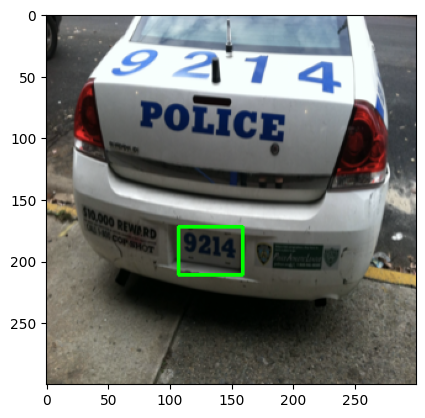

In [12]:
#view data in dataset
sample_image, sample_bbox = sample_batch
sample_image = np.copy(sample_image)
i = randint(0,7)

sample_bbox_image = draw_bbox(sample_image[i], sample_bbox[i])

plt.imshow(sample_bbox_image)
plt.show()

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D,Flatten, Concatenate
from tensorflow.keras.applications import VGG16

In [14]:
def build_model_ssd():
    input_layer = Input(shape=(image_dim, image_dim, 3))

    # # VGG16
    vgg = VGG16(include_top=False, input_tensor=input_layer)
    for layer in vgg.layers:
        layer.trainable = False

    # SSD addition
    activation1 = 'relu'
    padding = 'same'

    conv6 = Conv2D(1024, (3, 3), activation=activation1, padding=padding)(vgg.output)
    conv7 = Conv2D(1024, (1, 1), activation=activation1, padding=padding)(conv6)

    conv8_1 = Conv2D(256, (1, 1), activation=activation1, padding=padding)(conv7)
    conv8_2 = Conv2D(512, (3, 3), activation=activation1, strides=(2, 2), padding=padding)(conv8_1)

    conv9_1 = Conv2D(128, (1, 1), activation=activation1, padding=padding)(conv8_2)
    conv9_2 = Conv2D(256, (3, 3), activation=activation1, strides=(2, 2), padding=padding)(conv9_1)

    conv10_1 = Conv2D(128, (1, 1), activation=activation1, padding=padding)(conv9_2)
    conv10_2 = Conv2D(256, (3, 3), activation=activation1, strides=(2, 2), padding=padding)(conv10_1)

    conv11_1 = Conv2D(128, (1, 1), activation=activation1, padding=padding)(conv10_2)
    conv11_2 = Conv2D(256, (3, 3), activation=activation1, padding=padding)(conv11_1)

    # Bounding box regression
    bbox_regress = Conv2D(16, (3, 3), padding=padding)(conv11_2)
    bbox_regress = Flatten()(bbox_regress)
    bbox_regress = Dense(4, activation='sigmoid')(bbox_regress)

    plate_detection = Model(inputs=input_layer, outputs=bbox_regress)
    return plate_detection


In [15]:
plate_detection_model = build_model_ssd()
plate_detection_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                              

In [16]:
x_image, y_label = train_set.as_numpy_iterator().next()

In [17]:
x_image.shape

(8, 300, 300, 3)

In [18]:
#view if the predition are in the right form
coords = plate_detection_model.predict(x_image)
coords

1/1 [==============================] - 5s 5s/step


array([[0.4989862 , 0.49939522, 0.49675828, 0.49947426],
       [0.49984467, 0.4992702 , 0.49688664, 0.49931502],
       [0.49892917, 0.49897665, 0.4975155 , 0.499392  ],
       [0.49875933, 0.49961537, 0.4967665 , 0.4993408 ],
       [0.49869463, 0.4993712 , 0.4969292 , 0.49934772],
       [0.49874336, 0.49858695, 0.49730805, 0.49937683],
       [0.49878037, 0.50004953, 0.49669346, 0.49906018],
       [0.49764502, 0.4995466 , 0.4974447 , 0.49936077]], dtype=float32)

In [19]:
plate_detection_model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

In [20]:
history = plate_detection_model.fit(train_set, epochs=25)

Epoch 1/25
49/49 [==============================] - 16s 93ms/step - loss: 0.0154
Epoch 2/25
49/49 [==============================] - 9s 94ms/step - loss: 0.0121
Epoch 3/25
49/49 [==============================] - 9s 95ms/step - loss: 0.0083
Epoch 4/25
49/49 [==============================] - 9s 94ms/step - loss: 0.0054
Epoch 5/25
49/49 [==============================] - 9s 95ms/step - loss: 0.0047
Epoch 6/25
49/49 [==============================] - 9s 95ms/step - loss: 0.0036
Epoch 7/25
49/49 [==============================] - 9s 95ms/step - loss: 0.0027
Epoch 8/25
49/49 [==============================] - 9s 95ms/step - loss: 0.0023
Epoch 9/25
49/49 [==============================] - 9s 95ms/step - loss: 0.0020
Epoch 10/25
49/49 [==============================] - 9s 96ms/step - loss: 0.0018
Epoch 11/25
49/49 [==============================] - 9s 96ms/step - loss: 0.0016
Epoch 12/25
49/49 [==============================] - 9s 97ms/step - loss: 0.0013
Epoch 13/25
49/49 [=================

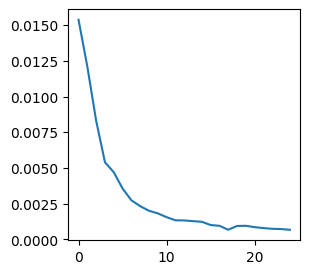

In [21]:
loss_values = list(history.history.values())[0]
epoch = list(range(0, len(loss_values)))
plt.figure(figsize = (3,3))
plt.plot(epoch, loss_values)
plt.show()

In [22]:
sample_batch = test_set.as_numpy_iterator().next()

# Prediction Step

1/1 [==============================] - 0s 193ms/step


[[0.3909 0.405  0.5537 0.4976]
 [0.295  0.3684 0.3726 0.401 ]
 [0.2042 0.3374 0.683  0.4775]
 [0.29   0.5845 0.6826 0.704 ]
 [0.305  0.66   0.655  0.7734]
 [0.105  0.4368 0.505  0.81  ]
 [0.765  0.7227 0.86   0.8013]
 [0.38   0.542  0.63   0.92  ]]
[[0.36616823 0.4190297  0.5406105  0.5027899 ]
 [0.28102103 0.3631288  0.37977508 0.42077282]
 [0.160116   0.35557142 0.6986392  0.5447872 ]
 [0.2873726  0.5602418  0.7029566  0.72372925]
 [0.30901393 0.6404438  0.6627957  0.7716531 ]
 [0.12007696 0.40013668 0.5415322  0.8084763 ]
 [0.68616676 0.7256428  0.82860696 0.80954033]
 [0.354622   0.55717254 0.6510169  0.90861696]]


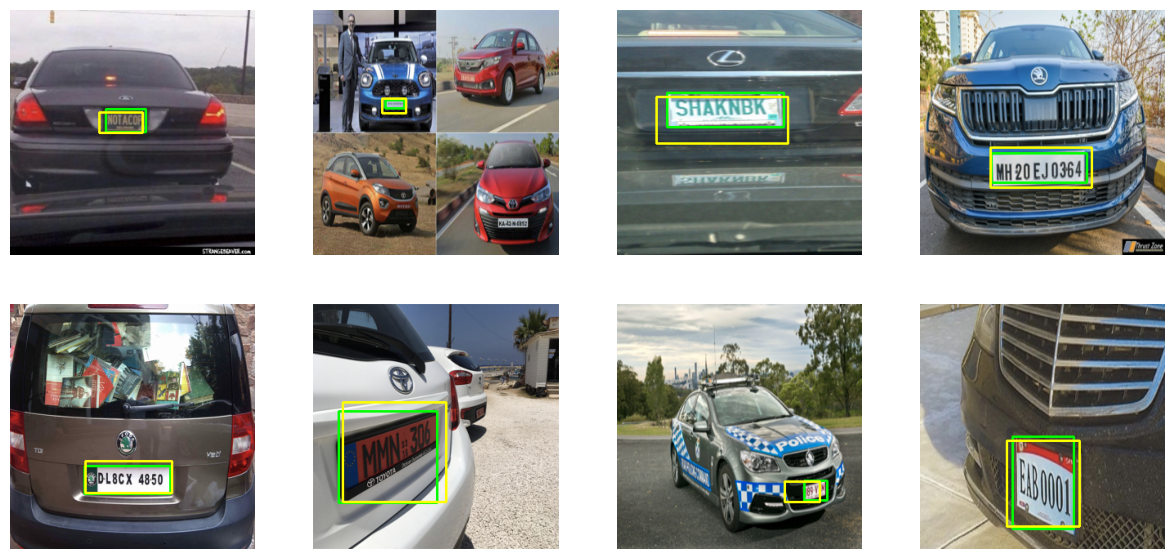

In [23]:
#First view of the predition
sample_image, sample_bbox = sample_batch
sample_image = np.copy(sample_image)
predict_bbox = plate_detection_model.predict(sample_image)
print(sample_bbox)
print(predict_bbox)
fig = plt.figure(figsize=(15,7))
row = 2
col = 4

for i in range(8):

  sample_bbox_image = draw_bbox(sample_image[i], sample_bbox[i], predict_bbox[i])

  fig.add_subplot(row, col,i+1)
  plt.axis("off")
  plt.imshow(sample_bbox_image)
plt.show()

In [24]:
def IOU(bbox1, bbox2):
  #bbox = [xmin,ymin,xmax,ymax]
  #finding intersection coords
  x1_intersection = max(bbox1[0], bbox2[0])
  x2_intersection = min(bbox1[2], bbox2[2])
  y1_intersection = max(bbox1[1], bbox2[1])
  y2_intersection = min(bbox1[3], bbox2[3])
  #bbox areas
  area_1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
  area_2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

  intersection_area =  (x2_intersection - x1_intersection) * (y2_intersection - y1_intersection)
  intersection_area = 0 if intersection_area < 0 else intersection_area

  union_area = (area_1 + area_2) - intersection_area
  iou = intersection_area / union_area
  return 0 if iou < 0 else iou

In [25]:
great_prediction = []
good_prediction = []
bad_prediction = []
all_iou = []
#place the IOU to different list depending on how good the prediction is
for i, (batch) in enumerate(test_set): #or train_set
  images, labels = batch
  predicted_labels = plate_detection_model.predict(images)
  for j, (label) in enumerate(predicted_labels):
    iou = IOU(labels[j].numpy(),label)
    data = [images[j], labels[j], label]
    all_iou.append(iou)
    if iou >= 0.8:
      great_prediction.append(data)
    elif iou >= 0.6:
      good_prediction.append(data)
    else:
      bad_prediction.append(data)

1/1 [==============================] - 1s 1s/step


1st Quartile 0.490204393863678
Median:  0.5759604498289708
3rd Quartile 0.7566718459129333
Mode:  0.7804538816213608


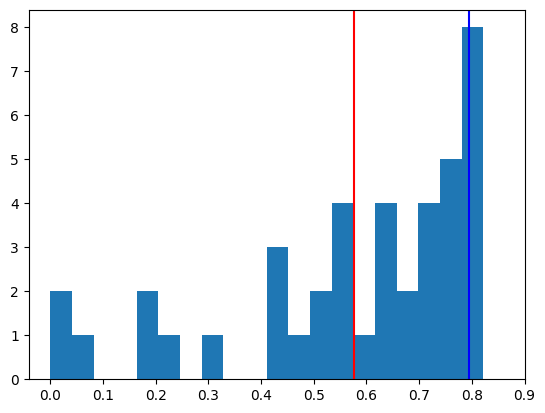

In [26]:
counts, bins, _ = plt.hist(all_iou, bins = 20)

Q1 = np.percentile(all_iou, 25)
Q3 = np.percentile(all_iou, 75)
median = np.mean(all_iou)
mode = bins[np.argmax(counts)]

print("1st Quartile", Q1)
print("Median: ", median)
print("3rd Quartile", Q3)
print("Mode: ", mode)

plt.xticks(np.arange(0,1,step= 0.1))
plt.axvline(median, color = 'r')
plt.axvline(mode+0.015, color = 'b') #+0.015 so it can appear in between the bar
plt.show()

In [27]:
print(len(great_prediction))
print(len(good_prediction))
print(len(bad_prediction))

3
20
18


In [28]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,702 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

# Displays Great, Good, and Bad predictions


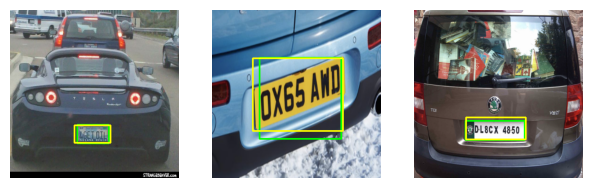

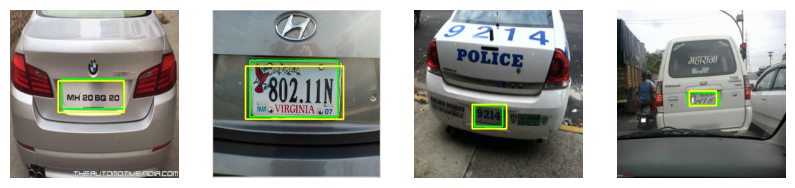

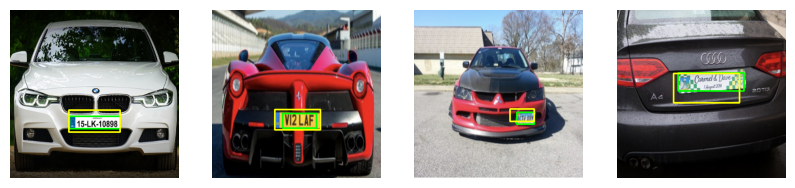

In [29]:
rows = [great_prediction, good_prediction, bad_prediction]

for row in rows:
  fig = plt.figure(figsize=(10,5))
  #This try section is for when 0 < len(row) < 4 or skips when 0
  try:
    sample_batch = sample(row,4)
  except:
    try:
      sample_batch = sample(row, len(rows))
    except:
      continue

  for i, (packed_data) in enumerate(sample_batch):

    sample_image, sample_bbox, predict_bbox = packed_data
    sample_image = np.copy(sample_image)
    sample_bbox = sample_bbox.numpy()

    sample_image = draw_bbox(sample_image, sample_bbox, predict_bbox)

    fig.add_subplot(1, 4,i+1)
    plt.axis("off")
    plt.imshow(sample_image)
  plt.show()

# Pytesseract OCR

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


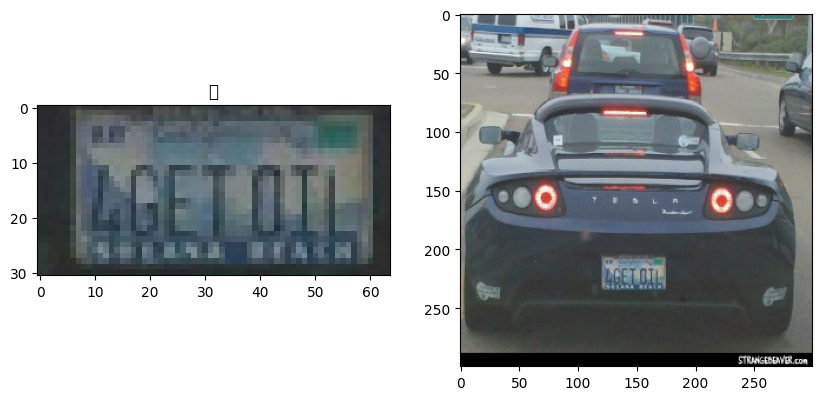

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


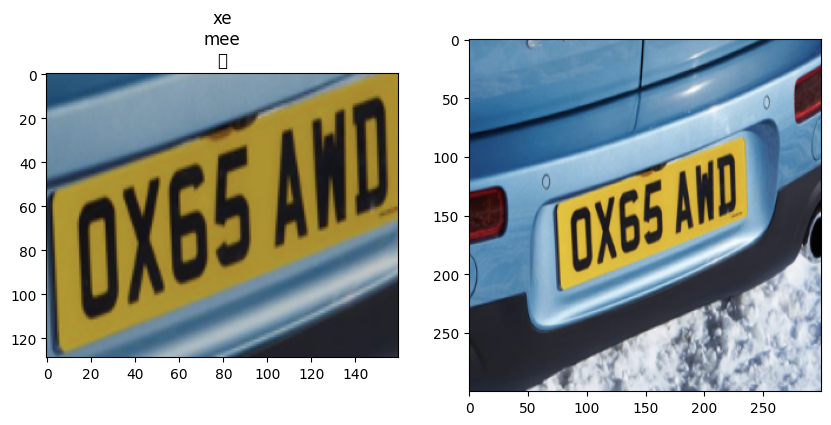

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


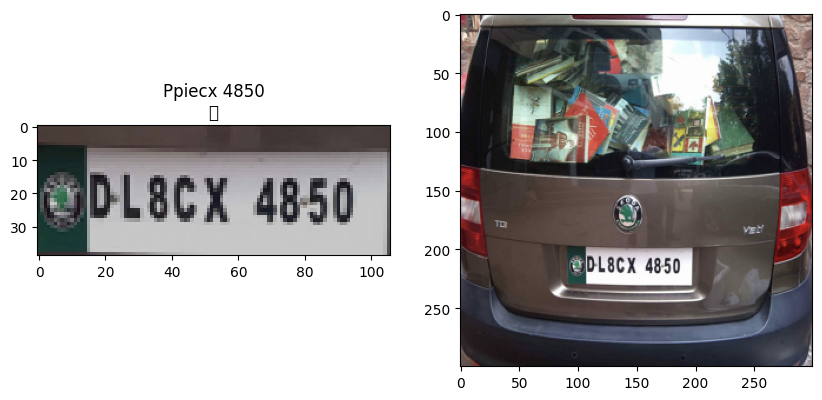

In [44]:
import pytesseract
from PIL import Image
# Will place the license plate as the title if pytesseract is able to predict it.
#rows = [great_prediction, good_prediction, bad_prediction]
for pack in rows[0]:
  fig = plt.figure(figsize=(10,7))
  original_image, bbox, pred = pack
  image = original_image.numpy()[int(pred[1]*image_dim):int(pred[3]*image_dim),int(pred[0]*image_dim):int(pred[2]*image_dim)]

  image = (image*200).astype(np.uint8)
  pil_image = Image.fromarray(image)
  LP_number = pytesseract.image_to_string(pil_image)

  fig.add_subplot(1, 2, 1)
  plt.imshow(pil_image)
  plt.title(LP_number)

  fig.add_subplot(1, 2,2)
  plt.imshow(original_image)

  plt.show()